[*********************100%***********************]  1 of 1 completed



 stock.head
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320429  24.789798  23.879978  24.778675  212818400
2015-01-05  23.635286  24.169166  23.448429  24.089084  257142000
2015-01-06  23.637512  23.897778  23.274918  23.699798  263188400
2015-01-07  23.968956  24.069058  23.735383  23.846608  160423600
2015-01-08  24.889902  24.947740  24.180287  24.298187  237458000

 stock.tail
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Open, AAPL)    2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes:

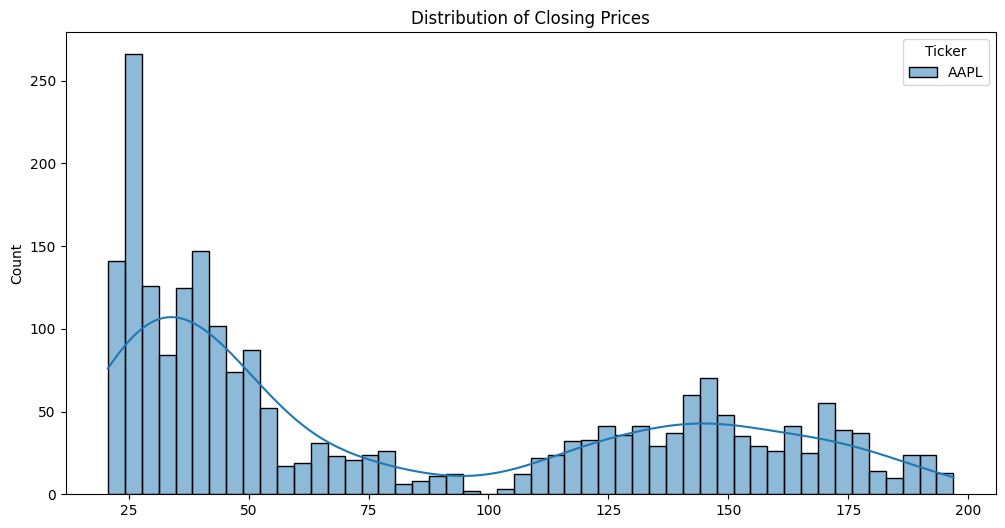

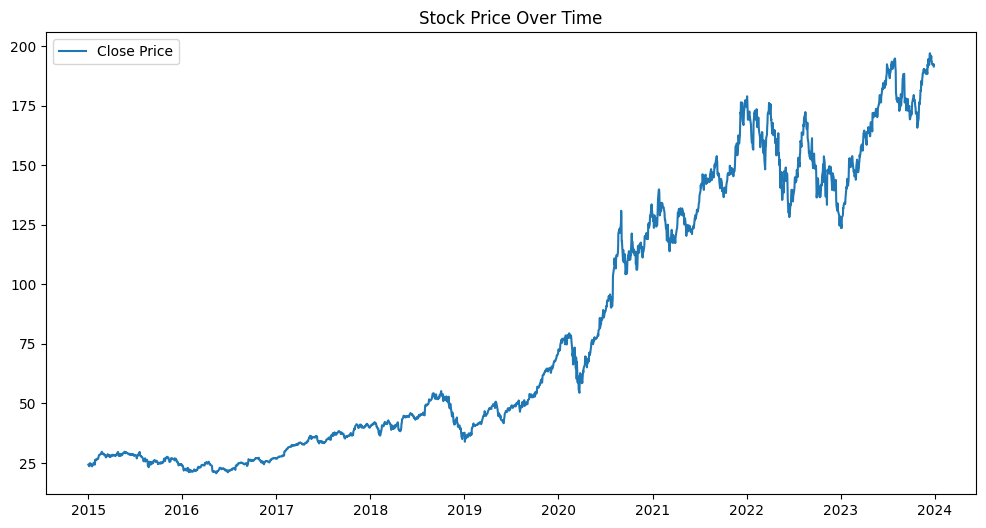

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0265 - val_loss: 0.0037
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 9.7020e-04 - val_loss: 0.0016
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 9.3949e-04 - val_loss: 0.0019
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0010 - val_loss: 9.5432e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.6391e-04 - val_loss: 0.0022
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.9715e-04 - val_loss: 0.0028
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - 

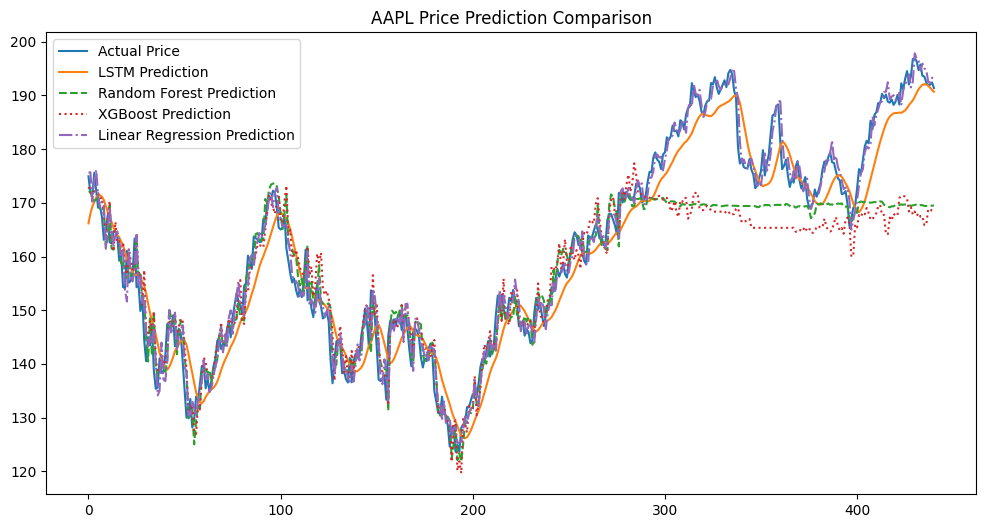

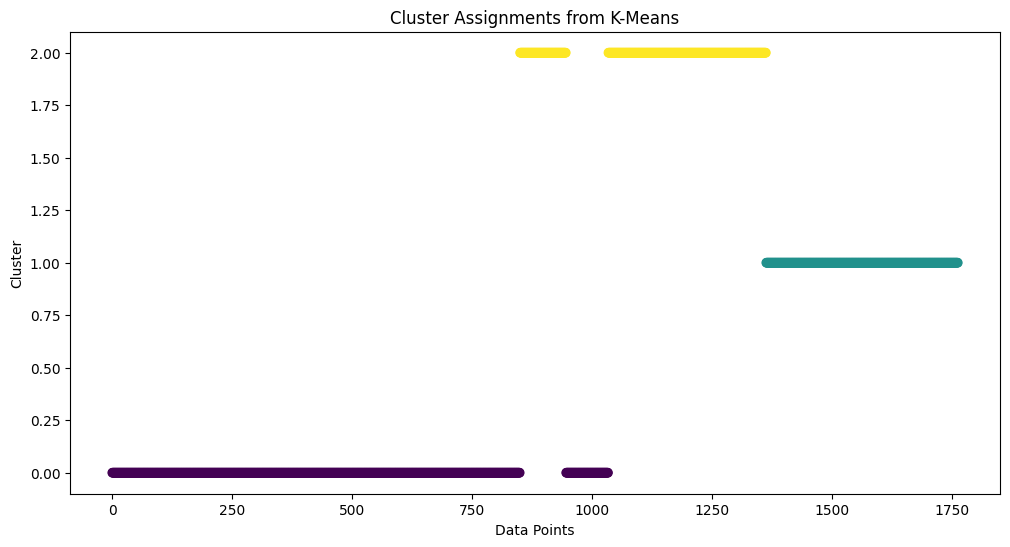

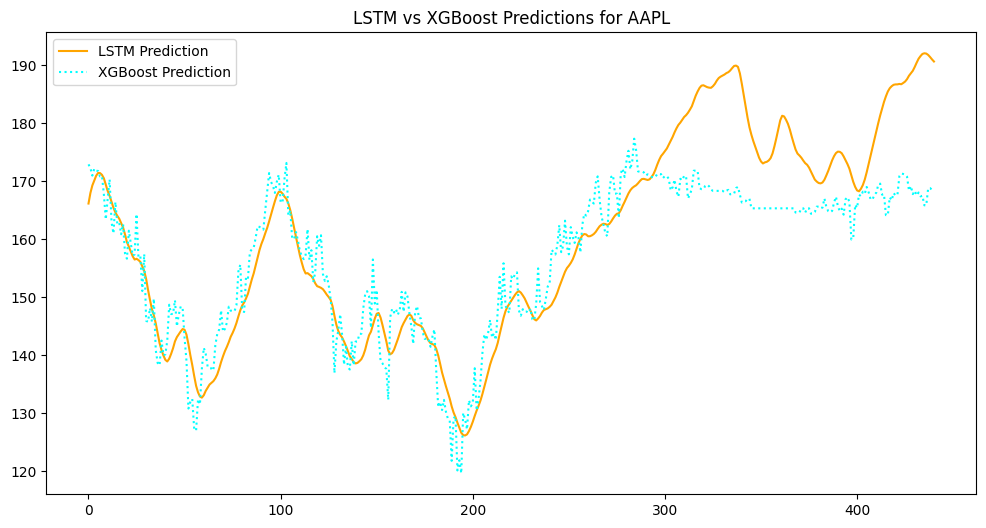

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def download_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    stock = yf.download(ticker, start=start, end=end)
    print("\n stock.head")
    print(stock.head())
    print("\n stock.tail")
    print(stock.info())
    print("\n stock.describe")
    print(stock.describe())
    return stock[['Close']]

def perform_eda(df):
    print("Summary Statistics:\n", df.describe())

    plt.figure(figsize=(12, 6))
    sns.histplot(df['Close'], bins=50, kde=True)
    plt.title('Distribution of Closing Prices')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.legend()
    plt.show()

def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled[i-time_steps:i, 0])
        y.append(df_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y, scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
linear_model = LinearRegression()
kmeans = KMeans(n_clusters=3, random_state=42)

if __name__ == "__main__":
    ticker = 'AAPL'
    stock_data = download_stock_data(ticker)

    perform_eda(stock_data)

    X, y, scaler = prepare_data(stock_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    lstm_model = build_lstm_model((X_train.shape[1], 1))
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    rf_model.fit(X_train_flat, y_train)
    xgb_model.fit(X_train_flat, y_train)
    linear_model.fit(X_train_flat, y_train)

    rf_predictions = rf_model.predict(X_test_flat).reshape(-1, 1)
    xgb_predictions = xgb_model.predict(X_test_flat).reshape(-1, 1)
    linear_predictions = linear_model.predict(X_test_flat).reshape(-1, 1)

    rf_predictions = scaler.inverse_transform(rf_predictions)
    xgb_predictions = scaler.inverse_transform(xgb_predictions)
    linear_predictions = scaler.inverse_transform(linear_predictions)

    clusters = kmeans.fit_predict(X_train_flat)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(lstm_predictions, label='LSTM Prediction')
    plt.plot(rf_predictions, label='Random Forest Prediction', linestyle='dashed')
    plt.plot(xgb_predictions, label='XGBoost Prediction', linestyle='dotted')
    plt.plot(linear_predictions, label='Linear Regression Prediction', linestyle='dashdot')
    plt.legend()
    plt.title(f'{ticker} Price Prediction Comparison')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(clusters)), clusters, c=clusters, cmap='viridis')
    plt.title('Cluster Assignments from K-Means')
    plt.xlabel('Data Points')
    plt.ylabel('Cluster')
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(lstm_predictions, label='LSTM Prediction', color='orange')
    plt.plot(xgb_predictions, label='XGBoost Prediction', color='cyan', linestyle='dotted')
    plt.legend()
    plt.title(f'LSTM vs XGBoost Predictions for {ticker}')
    plt.show()


[*********************100%***********************]  1 of 1 completed


Price           Close
Ticker           AAPL
Date                 
2015-01-02  24.320431
2015-01-05  23.635286
2015-01-06  23.637516
2015-01-07  23.968964
2015-01-08  24.889902
Price            Close
Ticker            AAPL
Date                  
2023-12-22  192.444595
2023-12-26  191.897873
2023-12-27  191.997253
2023-12-28  192.424698
2023-12-29  191.380966
Summary Statistics:
 Price         Close
Ticker         AAPL
count   2264.000000
mean      81.673040
std       56.182341
min       20.674534
25%       32.926900
50%       51.396002
75%      139.492989
max      196.927658


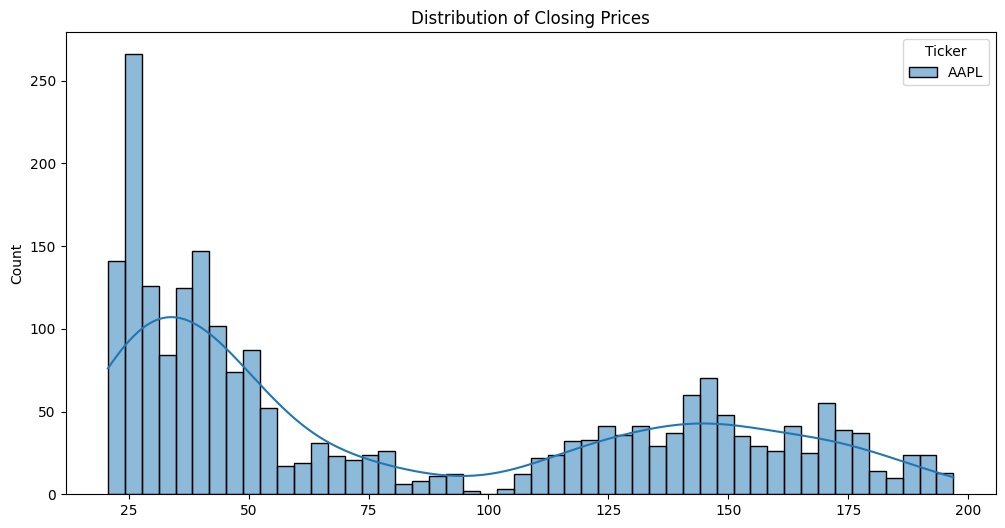

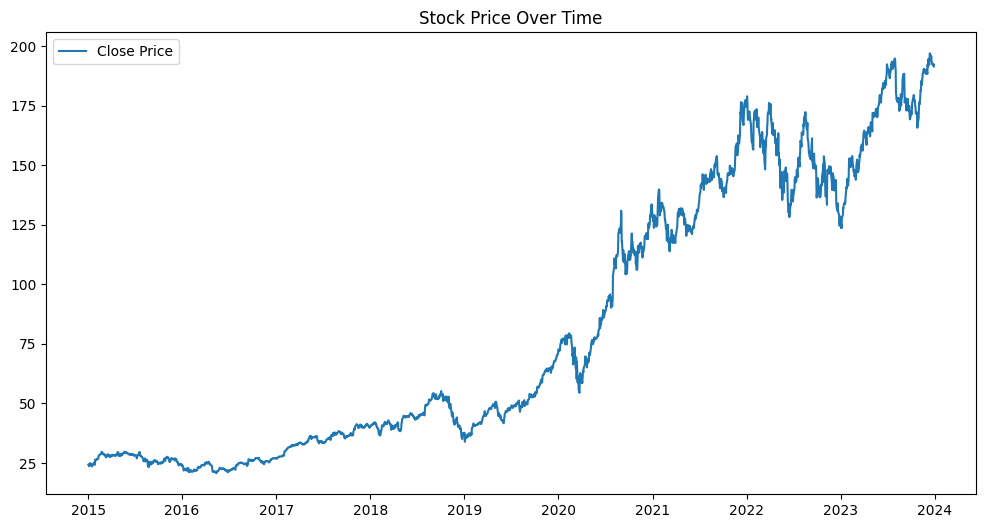

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 0.0237 - val_loss: 0.0015
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.5748e-04 - val_loss: 0.0026
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 8.5479e-04 - val_loss: 0.0012
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 8.7478e-04 - val_loss: 0.0017
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9

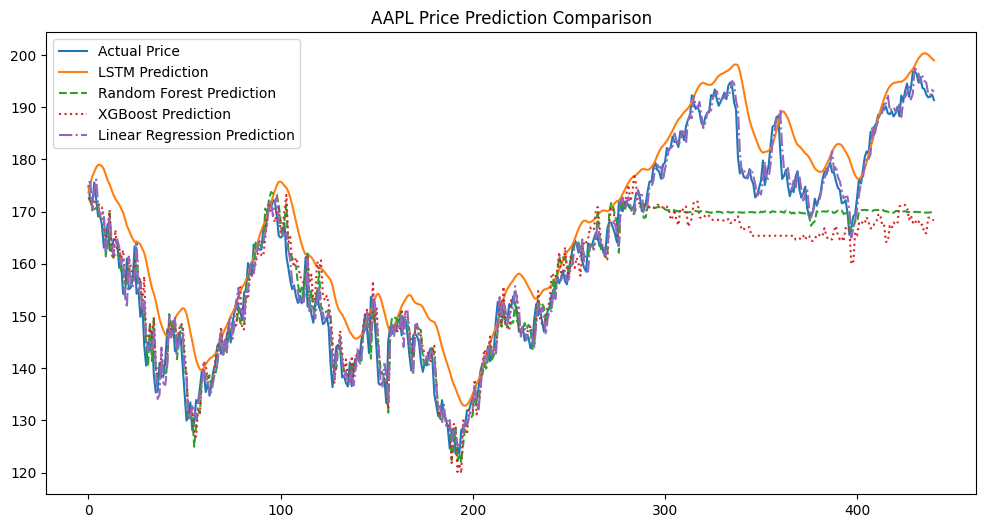

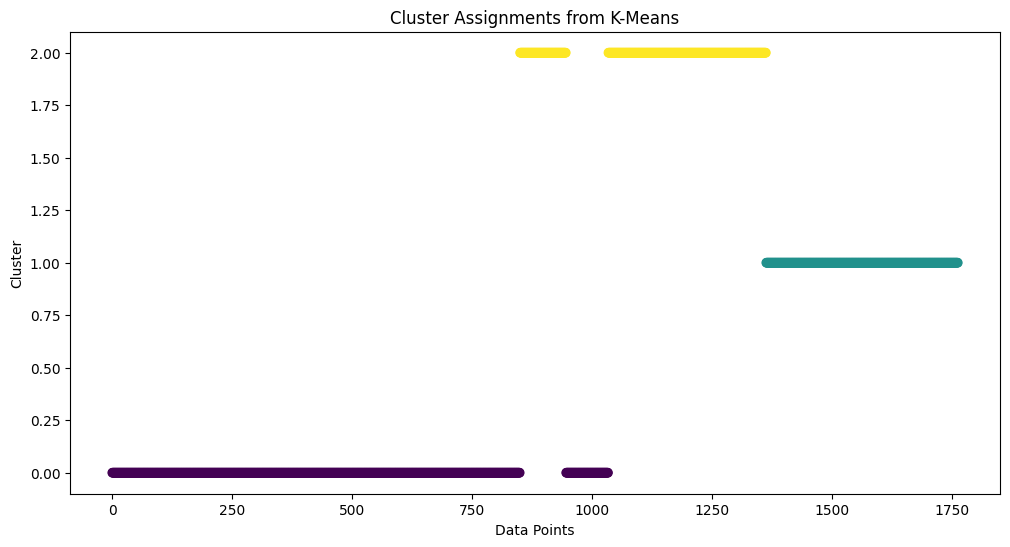

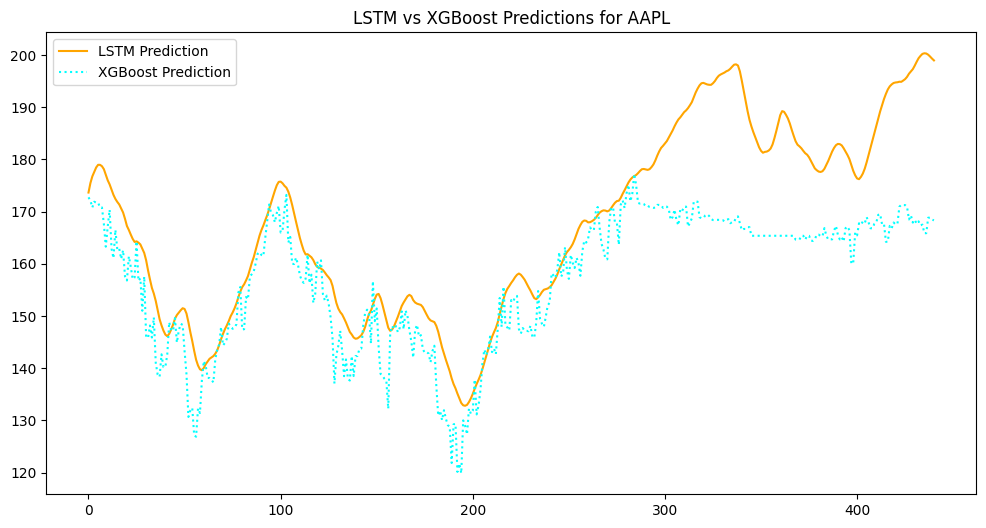

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def download_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    stock = yf.download(ticker, start=start, end=end)

    # Удаляем будущие данные и сортируем по дате
    stock = stock[['Close']].dropna().sort_index()

    print(stock.head())
    print(stock.tail())
    return stock

def perform_eda(df):
    print("Summary Statistics:\n", df.describe())

    plt.figure(figsize=(12, 6))
    sns.histplot(df['Close'], bins=50, kde=True)
    plt.title('Distribution of Closing Prices')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.legend()
    plt.show()

def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled[i-time_steps:i, 0])
        y.append(df_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y, scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
linear_model = LinearRegression()
kmeans = KMeans(n_clusters=3, random_state=42)

if __name__ == "__main__":
    ticker = 'AAPL'
    stock_data = download_stock_data(ticker)

    perform_eda(stock_data)

    X, y, scaler = prepare_data(stock_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    lstm_model = build_lstm_model((X_train.shape[1], 1))
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    rf_model.fit(X_train_flat, y_train)
    xgb_model.fit(X_train_flat, y_train)

    linear_model = LinearRegression()

    linear_model.fit(X_train_flat, y_train)

    rf_predictions = rf_model.predict(X_test_flat).reshape(-1, 1)
    xgb_predictions = xgb_model.predict(X_test_flat).reshape(-1, 1)
    linear_predictions = linear_model.predict(X_test_flat).reshape(-1, 1)

    rf_predictions = scaler.inverse_transform(rf_predictions)
    xgb_predictions = scaler.inverse_transform(xgb_predictions)
    linear_predictions = scaler.inverse_transform(linear_predictions)

    clusters = kmeans.fit_predict(X_train_flat)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(lstm_predictions, label='LSTM Prediction')
    plt.plot(rf_predictions, label='Random Forest Prediction', linestyle='dashed')
    plt.plot(xgb_predictions, label='XGBoost Prediction', linestyle='dotted')
    plt.plot(linear_predictions, label='Linear Regression Prediction', linestyle='dashdot')
    plt.legend()
    plt.title(f'{ticker} Price Prediction Comparison')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(clusters)), clusters, c=clusters, cmap='viridis')
    plt.title('Cluster Assignments from K-Means')
    plt.xlabel('Data Points')
    plt.ylabel('Cluster')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(lstm_predictions, label='LSTM Prediction', color='orange')
    plt.plot(xgb_predictions, label='XGBoost Prediction', color='cyan', linestyle='dotted')
    plt.legend()
    plt.title(f'LSTM vs XGBoost Predictions for {ticker}')
    plt.show()


[*********************100%***********************]  1 of 1 completed


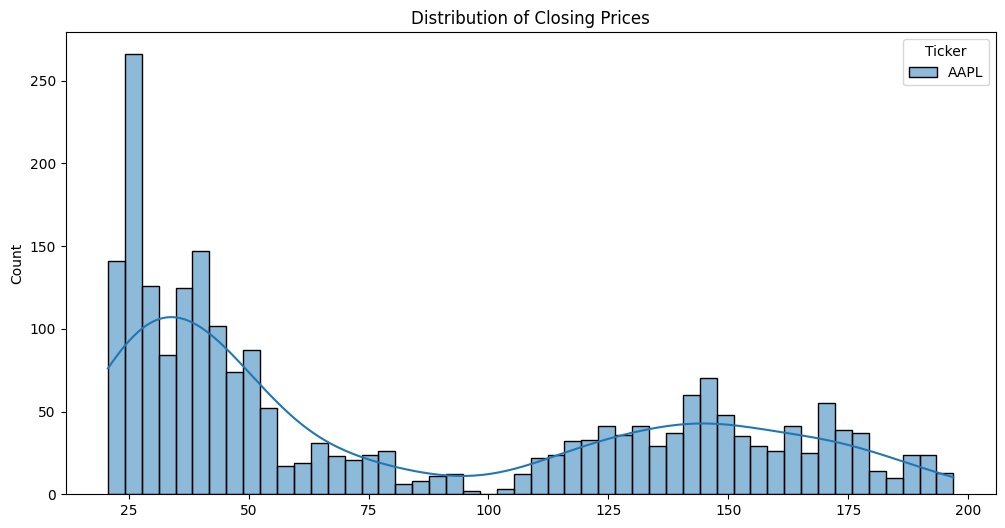

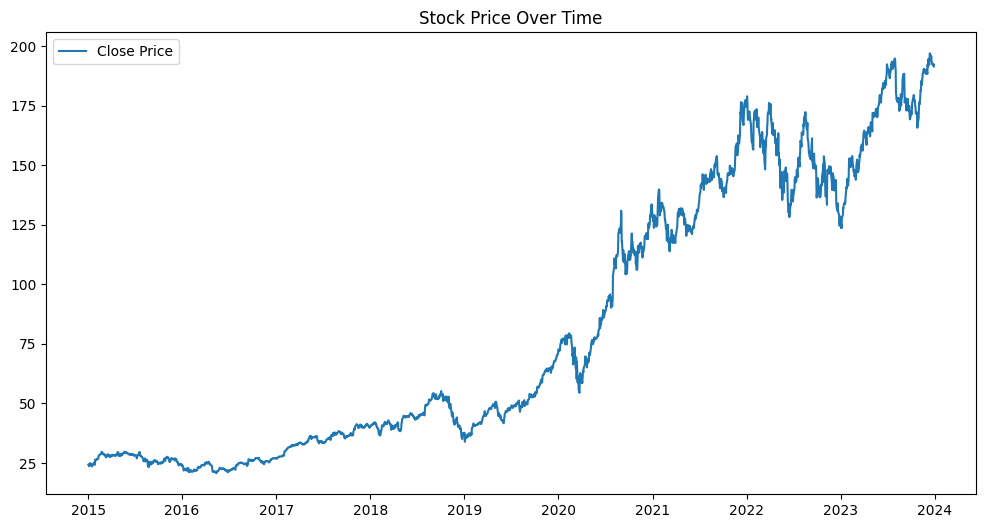

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0232 - val_loss: 0.0016
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 9.0049e-04 - val_loss: 0.0011
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 9.2463e-04 - val_loss: 0.0026
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 7.1829e-04 - val_loss: 0.0014
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/ste

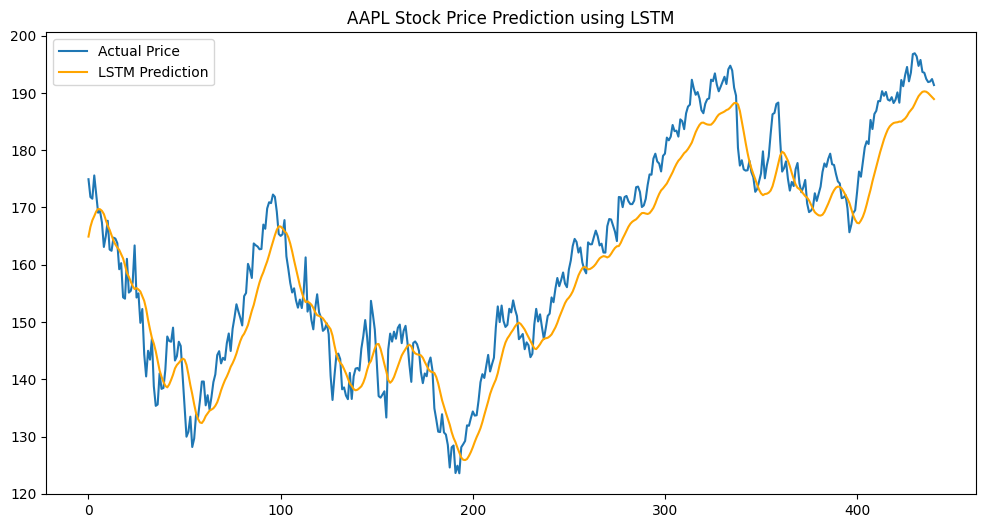

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def download_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    stock = yf.download(ticker, start=start, end=end)
    stock = stock[['Close']].sort_index()
    return stock

def perform_eda(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Close'], bins=50, kde=True)
    plt.title('Distribution of Closing Prices')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.legend()
    plt.show()

def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled[i-time_steps:i, 0])
        y.append(df_scaled[i, 0])

    return np.array(X).reshape(len(X), time_steps, 1), np.array(y), scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

if __name__ == "__main__":
    ticker = 'AAPL'
    stock_data = download_stock_data(ticker)
    perform_eda(stock_data)

    X, y, scaler = prepare_data(stock_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    lstm_model = build_lstm_model((X_train.shape[1], 1))
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(lstm_predictions, label='LSTM Prediction', color='orange')
    plt.legend()
    plt.title(f'{ticker} Stock Price Prediction using LSTM')
    plt.show()

[*********************100%***********************]  1 of 1 completed


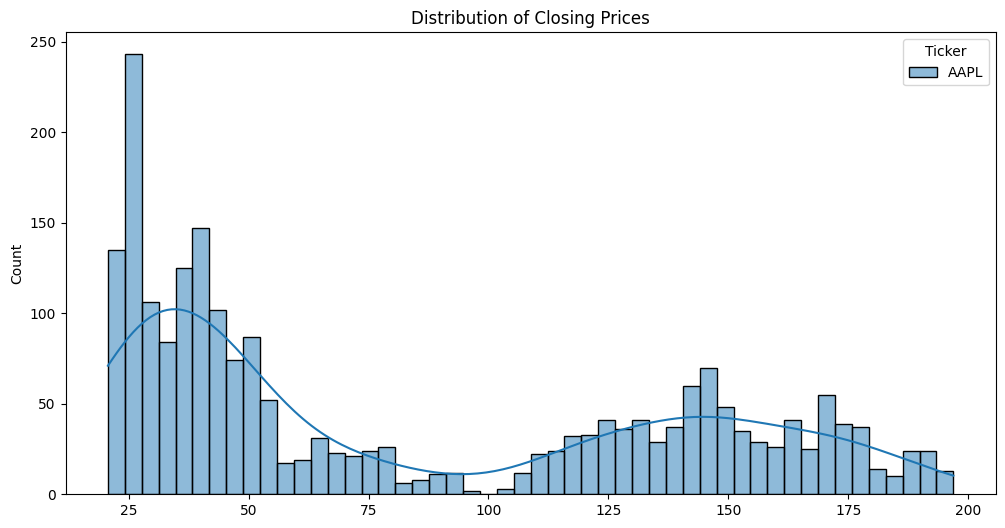

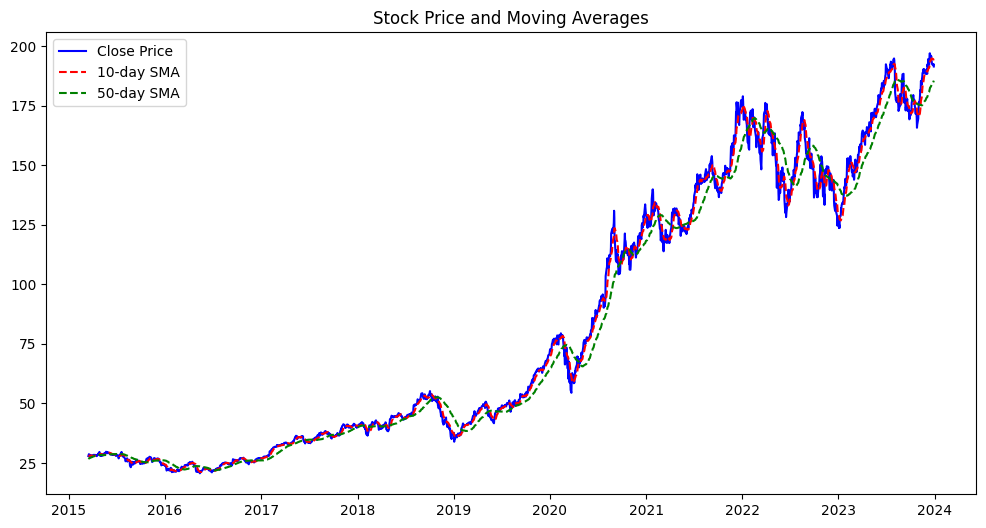

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - loss: 0.0222 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - loss: 0.0022 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - loss: 0.0018 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0015 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0012 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - loss: 9.3072e-04 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - loss: 0.0015 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 0.0016 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 9.6779e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoc

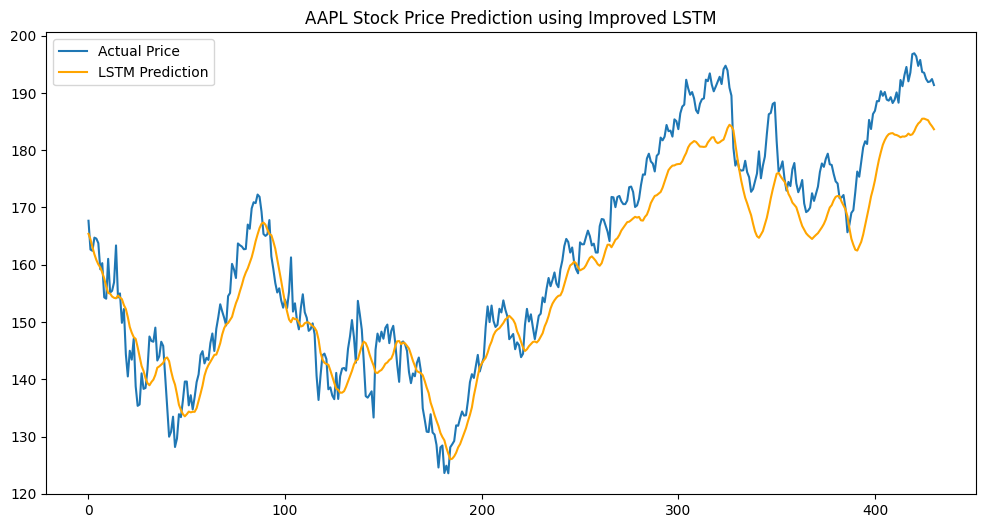

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def download_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    stock = yf.download(ticker, start=start, end=end)
    stock['SMA_10'] = stock['Close'].rolling(window=10).mean()
    stock['SMA_50'] = stock['Close'].rolling(window=50).mean()
    stock['RSI'] = compute_rsi(stock['Close'])
    stock.dropna(inplace=True)
    return stock[['Close', 'Volume', 'SMA_10', 'SMA_50', 'RSI']]

def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def perform_eda(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Close'], bins=50, kde=True)
    plt.title('Distribution of Closing Prices')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_10'], label='10-day SMA', linestyle='dashed', color='red')
    plt.plot(df.index, df['SMA_50'], label='50-day SMA', linestyle='dashed', color='green')
    plt.title('Stock Price and Moving Averages')
    plt.legend()
    plt.show()

def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled[i-time_steps:i])
        y.append(df_scaled[i, 0])

    return np.array(X), np.array(y), scaler

def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(100, return_sequences=True, input_shape=input_shape)),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

if __name__ == "__main__":
    ticker = 'AAPL'
    stock_data = download_stock_data(ticker)
    perform_eda(stock_data)

    X, y, scaler = prepare_data(stock_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                   callbacks=[early_stop, reduce_lr])

    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(np.hstack((lstm_predictions, np.zeros((lstm_predictions.shape[0], X.shape[2]-1)))))[:, 0]
    y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1)))))[:, 0]

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(lstm_predictions, label='LSTM Prediction', color='orange')
    plt.legend()
    plt.title(f'{ticker} Stock Price Prediction using Improved LSTM')
    plt.show()
